In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import string
import nltk
from collections import Counter
from nltk.corpus import stopwords
from spacy.tokens import DocBin
import numpy as np
from tqdm import tqdm


In [62]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,30 mins 42 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_vegito_rx3c0i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.912 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [41]:
from nltk.stem.snowball import SnowballStemmer

In [42]:
stemmer = SnowballStemmer("english")
stop_list = list(stopwords.words('english'))
stop_list.extend('empty wow'.split())

In [43]:
df = pd.read_csv("data/spam_text.csv")

In [44]:
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [4]:
df.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [5]:
df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [6]:
spam = df[df["label"] == "spam"]
spam.head()

,label,message,length,punct
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147,8
8,spam,WINNER!! As a valued network customer you have...,157,6
9,spam,Had your mobile 11 months or more? U R entitle...,154,2
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136,8


In [7]:
ham = df[df["label"] == "ham"]
ham.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2
6,ham,Even my brother is not like to speak with me. ...,77,2


In [8]:
spam.shape, ham.shape

((747, 4), (4825, 4))

In [9]:
ham = ham.sample(spam.shape[0])

In [10]:
spam.shape, ham.shape

((747, 4), (747, 4))

In [11]:
data = ham.append(spam,ignore_index=True)

In [12]:
data.tail()

,label,message,length,punct
1489,spam,Want explicit SEX in 30 secs? Ring 02073162414...,90,3
1490,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,158,5
1491,spam,Had your contract mobile 11 Mnths? Latest Moto...,160,8
1492,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147,3
1493,spam,This is the 2nd time we have tried 2 contact u...,160,8


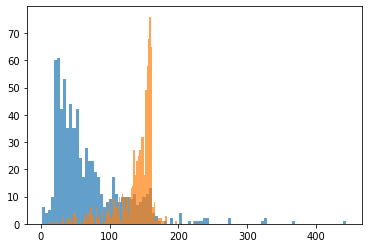

In [13]:
plt.hist(data[data["label"] == "ham"]["length"],bins=100,alpha=0.7)
plt.hist(data[data["label"] == "spam"]["length"],bins=100,alpha=0.7)
plt.show()

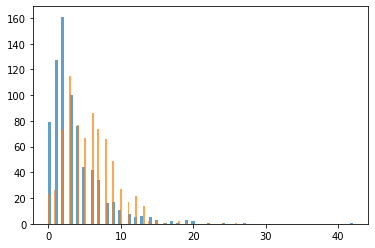

In [14]:
plt.hist(data[data["label"] == "ham"]["punct"],bins=100,alpha=0.7)
plt.hist(data[data["label"] == "spam"]["punct"],bins=100,alpha=0.7)
plt.show()

## Data Prepartion

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
data.head()

,label,message,length,punct
0,ham,Sorry i cant take your call right now. It so h...,368,10
1,ham,"Hurry up, I've been weed-deficient for like th...",54,3
2,ham,"Mostly sports type..lyk footbl,crckt..",38,5
3,ham,Ha... Both of us doing e same thing. But i got...,123,8
4,ham,East coast,10,0


In [18]:
x_train,x_test,y_train,y_test = train_test_split(data["message"],data["label"],test_size=0.2,random_state=42,shuffle=data["label"])

# Bag of Words

In [49]:
def tokenize(text):
    tokens = [word for word in nltk.word_tokenize(text) if len(word) > 1 and word.isalpha()]
    tokens = [stemmer.stem(word).lower() for word in tokens if word not in stop_list]
    return tokens

In [50]:
vectorizer = TfidfVectorizer(tokenizer=tokenize,max_df=0.75,max_features=1000,lowercase=False,ngram_range=(1,2))

In [51]:
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.fit_transform(x_test)

In [57]:
train_df = pd.DataFrame(train_vectors.toarray(),columns=vectorizer.get_feature_names())
train_df = pd.concat([train_df,y_train.reset_index(drop=True)],axis=1)
train_df.head()

,abl,abt,access,account,account statement,actual,addamsfa,addamsfa munster,age,ah,...,you won,your,your account,your mobil,your prize,yr,yr prize,yrs,yup,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.279272,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ham
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ham
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,spam
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ham
4,0.0,0.0,0.0,0.0,0.0,0.0,0.361351,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,spam


In [58]:
test_df = pd.DataFrame(test_vectors.toarray(),columns=vectorizer.get_feature_names())
test_df = pd.concat([test_df,y_test.reset_index(drop=True)],axis=1)
test_df.head()

,abl,abt,access,account,account statement,actual,addamsfa,addamsfa munster,age,ah,...,you won,your,your account,your mobil,your prize,yr,yr prize,yrs,yup,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.148681,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,spam
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,spam
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,spam
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,spam
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.200534,0.0,0.264097,0.0,0.0,0.0,0.0,0.0,spam


In [60]:
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [76]:
aml = H2OAutoML(seed=10,verbosity="info",nfolds=0,balance_classes=True)

In [77]:
x=vectorizer.get_feature_names()
y="label"

In [79]:
aml.train(x=x,y=y,training_frame=h2o_train_df,validation_frame=h2o_test_df)

AutoML progress: |
11:45:44.661: Project: AutoML_20210517_114544661
11:45:44.661: Cross-validation disabled by user: no fold column nor nfolds > 1.
11:45:44.661: User didn't set any runtime constraints (max runtime or max models), using default 1h time limit
11:45:44.661: Setting stopping tolerance adaptively based on the training frame: 0.028927842707018585
11:45:44.661: Build control seed: 10
11:45:44.661: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
11:45:44.772: training frame: Frame key: automl_training_Key_Frame__upload_bda813b127bcd89ace4c72baba294ffe.hex    cols: 1001    rows: 1075  chunks: 2    size: 283259  checksum: -753977348797747520
11:45:44.772: validation frame: Frame key: Key_Frame__upload_958d2b4fc3237d70d9a206e37e77408e.hex    cols: 1001    rows: 299  chunks: 1    size: 116394  checksum: -6056817919621782564
11:45:44.778: leaderboard frame: Fram

In [80]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XRT_1_AutoML_20210517_114544,0.995192,0.25271,0.996042,0.0288462,0.252672,0.063843
XRT_1_AutoML_20210517_114848,0.995192,0.25271,0.996042,0.0288462,0.252672,0.063843
GBM_grid__1_AutoML_20210517_114848_model_94,0.994627,0.215642,0.995907,0.0361991,0.23361,0.0545738
XGBoost_grid__1_AutoML_20210517_114848_model_94,0.994061,0.194501,0.995492,0.0480769,0.233087,0.0543297
DRF_1_AutoML_20210517_114848,0.993495,0.265254,0.995052,0.0458145,0.263105,0.0692244
DRF_1_AutoML_20210517_114544,0.993495,0.265254,0.995052,0.0458145,0.263105,0.0692244
GBM_grid__1_AutoML_20210517_114848_model_18,0.992647,0.233011,0.994575,0.043552,0.242267,0.0586931
DeepLearning_grid__1_AutoML_20210517_114848_model_9,0.992364,0.450174,0.995508,0.0147059,0.206628,0.0426952
DeepLearning_grid__2_AutoML_20210517_114848_model_8,0.992364,0.152153,0.994614,0.0316742,0.180723,0.0326609
GBM_grid__1_AutoML_20210517_114848_model_16,0.991799,0.22387,0.994155,0.0367647,0.242323,0.0587203


In [81]:
aml.leader.predict(h2o_test_df)

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,ham,spam
spam,0.723776,0.276224
spam,0.626266,0.373734
spam,0.352781,0.647219
spam,0.792056,0.207944
spam,0.532474,0.467526
spam,0.730319,0.269681
spam,0.539031,0.460969
spam,0.567243,0.432757
spam,0.801157,0.198843
spam,0.764216,0.235784


## Pipeline and RF

In [44]:
clf = Pipeline(
    [
        ("tfidf",TfidfVectorizer()), 
        ("clf", RandomForestClassifier(n_estimators=100,n_jobs=-1))
    ]
)

In [45]:
clf.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                               

In [49]:
y_pred = clf.predict(x_test)

In [50]:
confusion_matrix(y_test,y_pred)

array([[145,   0],
       [ 17, 137]])

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.90      0.99      0.94       145
        spam       0.99      0.90      0.94       154

    accuracy                           0.94       299
   macro avg       0.95      0.94      0.94       299
weighted avg       0.95      0.94      0.94       299



In [68]:
accuracy_score(y_test,y_pred)

0.9431438127090301

In [69]:
clf.predict(["hi how are you"])

array(['ham'], dtype=object)

In [70]:
clf.predict(["Congrats!, you have won free ticket for USA this summer, Text 'WON' to 546525"])

array(['spam'], dtype=object)

In [80]:
clf = Pipeline(
    [
        ("tfidf",TfidfVectorizer()), 
        ("clf", SVC(C=2000, gamma="auto"))
    ]
)

In [81]:
clf.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=2000, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='aut

In [82]:
y_pred = clf.predict(x_test)

In [83]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.92      0.98      0.95       145
        spam       0.98      0.92      0.95       154

    accuracy                           0.95       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.95      0.95      0.95       299



In [84]:
accuracy_score(y_test,y_pred)

0.9464882943143813

In [85]:
clf.predict(["hi how are you"])

array(['ham'], dtype=object)

In [86]:
clf.predict(["Congrats!, you have won free ticket for USA this summer, Text 'WON' to 546525"])

array(['spam'], dtype=object)

## EDA

In [292]:
nlp = spacy.load("en_core_web_sm") 
punctuations = string.punctuation


In [187]:
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stop_list and tok not in punctuations and tok.isalpha() and len(tok) > 1 ]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)


In [188]:
ham_clean_text = cleanup_text(data[data["label"]=="ham"]["message"])
ham_clean_text = ' '.join(ham_clean_text).split()
spam_clean_text = cleanup_text(data[data["label"]=="spam"]["message"])
spam_clean_text = ' '.join(spam_clean_text).split()


In [189]:
ham_counts = Counter(ham_clean_text)
spam_counts = Counter(spam_clean_text)

In [190]:
ham_common_words = [word[0] for word in ham_counts.most_common(20)]
ham_common_counts = [word[1] for word in ham_counts.most_common(20)]

spam_common_words = [word[0] for word in spam_counts.most_common(20)]
spam_common_counts = [word[1] for word in spam_counts.most_common(20)]



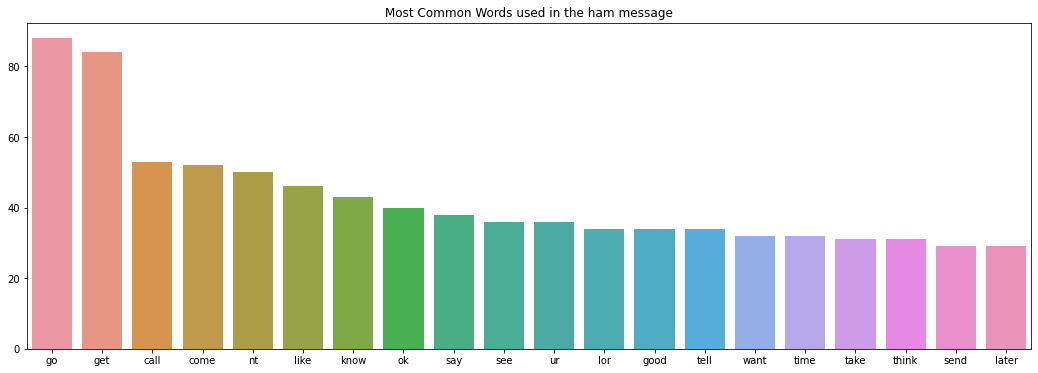

In [191]:
fig = plt.figure(figsize=(18,6))
sns.barplot(x=ham_common_words, y=ham_common_counts)
plt.title('Most Common Words used in the ham message')
plt.show()

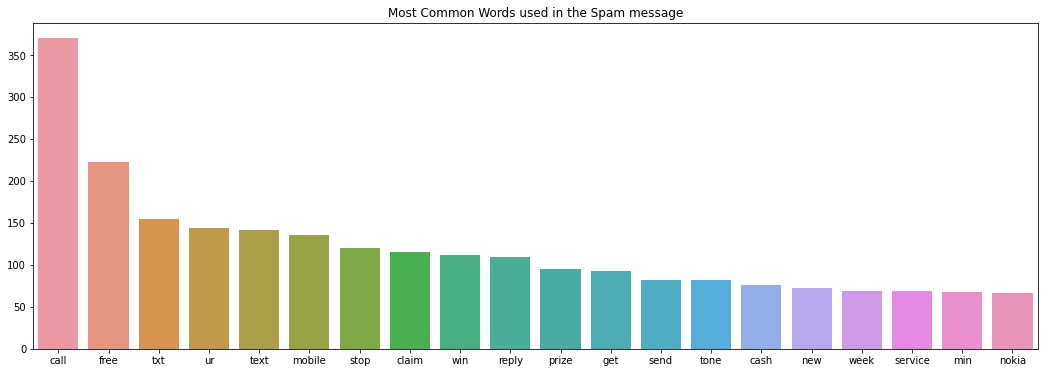

In [192]:
fig = plt.figure(figsize=(18,6))
sns.barplot(x=spam_common_words, y=spam_common_counts)
plt.title('Most Common Words used in the Spam message')
plt.show()